In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))
CosmicShearSimulator = cosmic_shear.TomographicCosmicShearDE(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, 
                                                           sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    return CosmicShearSimulator.simulate(theta, seed)

# Simulator arguments
simulator_args = None

In [3]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7, -1.5])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3, 1.5])
prior_mean = np.array([0.3, 0.8, 0.02237, 0.674, 0.96, -1.0])
prior_covariance = np.eye(6)*np.array([0.1, 0.1, 0.00015, 0.005, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.02237, 0.674, 0.96, -1.0])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
step = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, step)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=prior_mean, prior_covariance=prior_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(C, compressor_args)
#data = compressor(simulator(theta_fiducial, 0, simulator_args), compressor_args)

In [6]:
# Create the neural density estimator (MDN)
MDN = ndes.MixtureDensityNetwork(n_inputs=6, n_outputs=6, n_components=3, n_hidden=[25,25], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b h^2', 'h', 'n_s', 'w_0'], 
                       results_dir = "simulators/cosmic_shear/results_darkenergy/mdn_1000_")

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


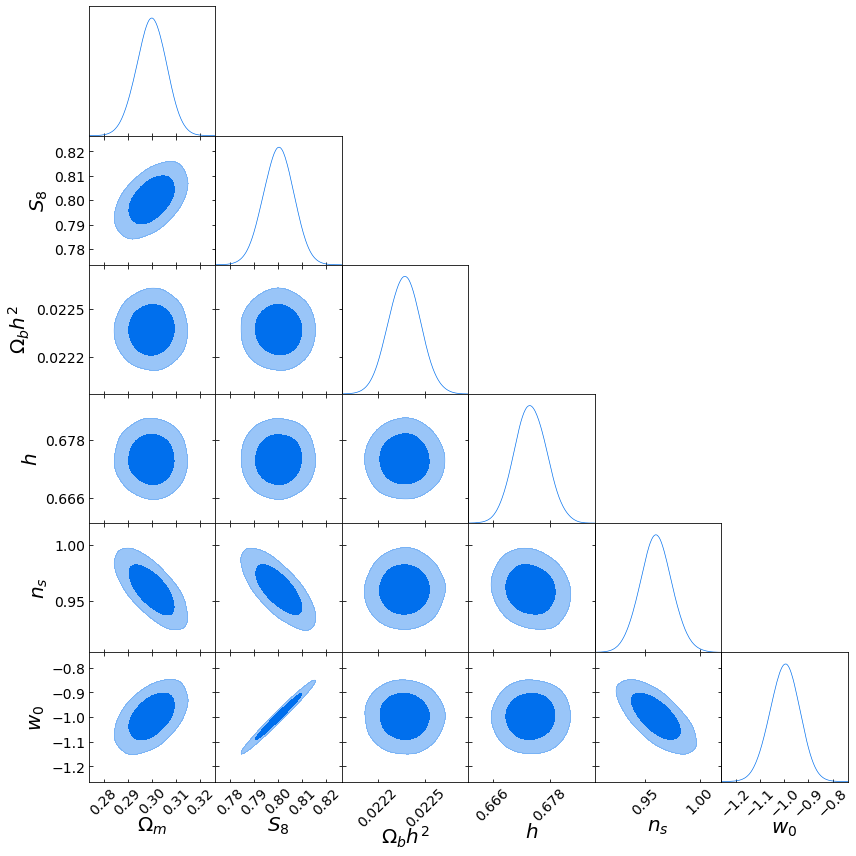

In [9]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


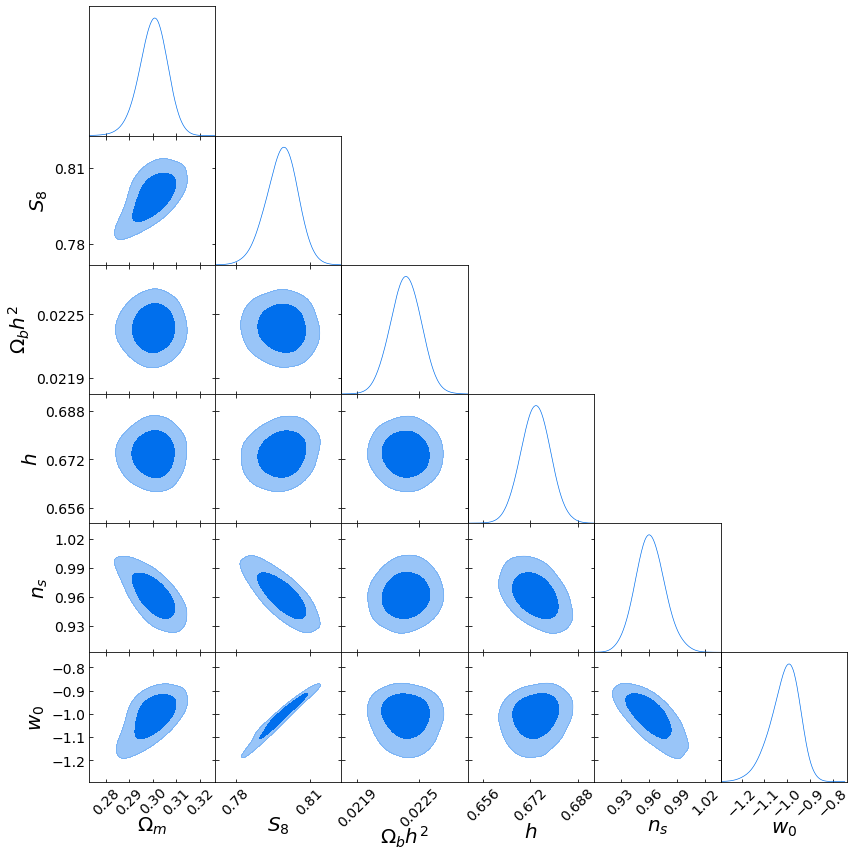

Population 1/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


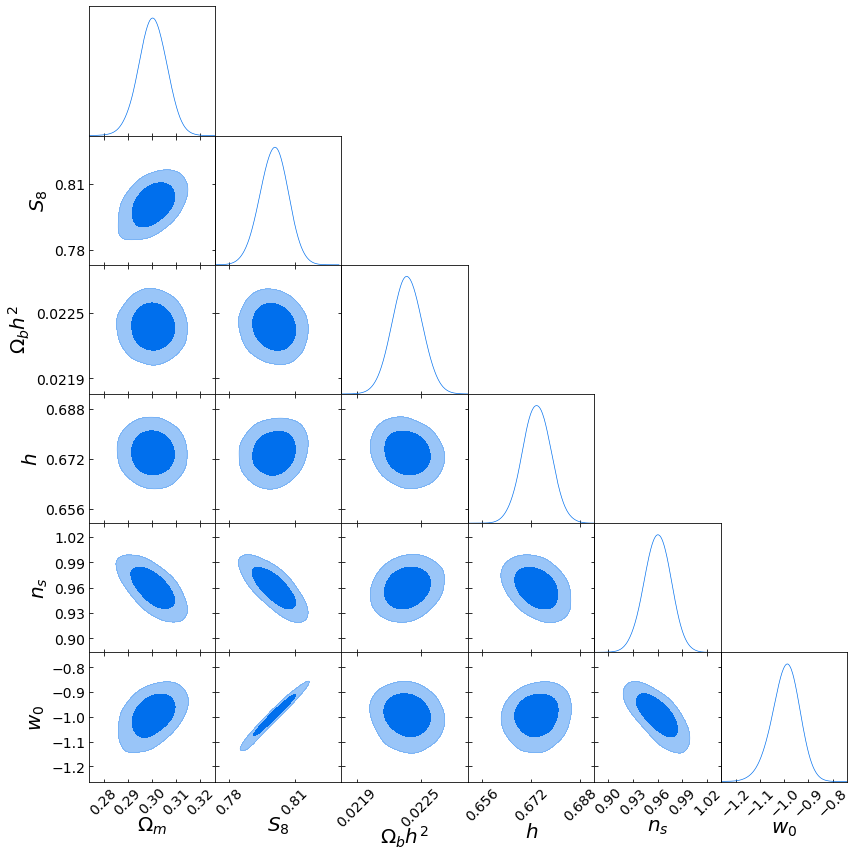

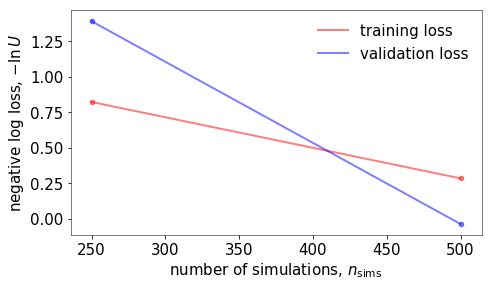

Population 2/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


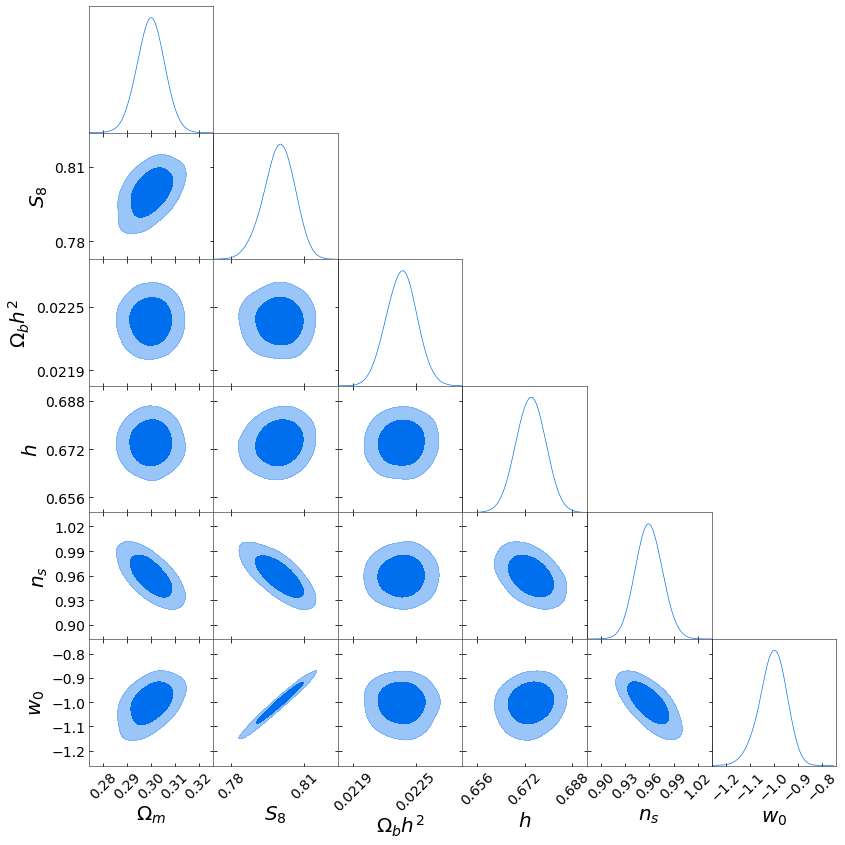

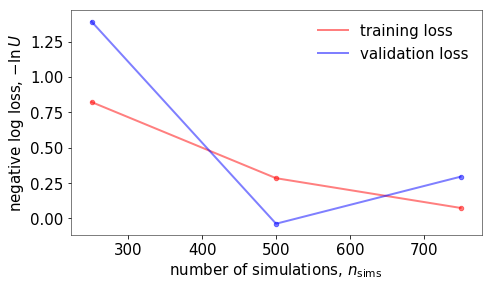

Population 3/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


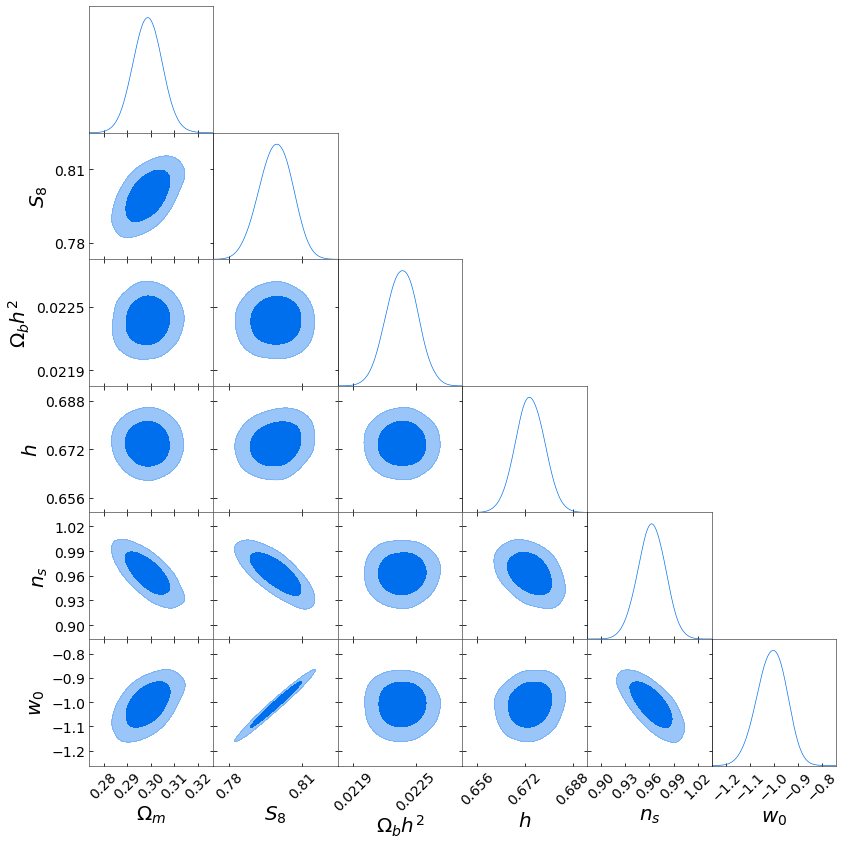

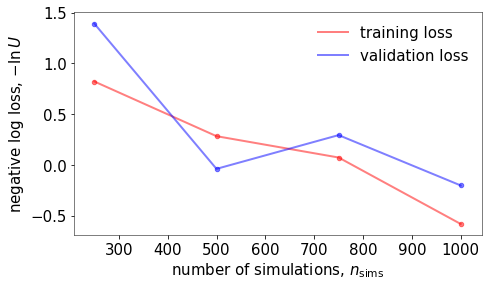

Population 4/47
Sampling proposal density...
Done.


Simulator returns exception for parameter values: [ 0.29844978  0.80251408  0.02248004  0.68201701  0.96130918 -0.97650808] (rank 0)
Simulator returns exception for parameter values: [ 0.29218929  0.79662882  0.02253834  0.68563682  0.94663452 -1.03570115] (rank 0)


Sampling approximate posterior...


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 250
n_batch = 250
n_populations = 47

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


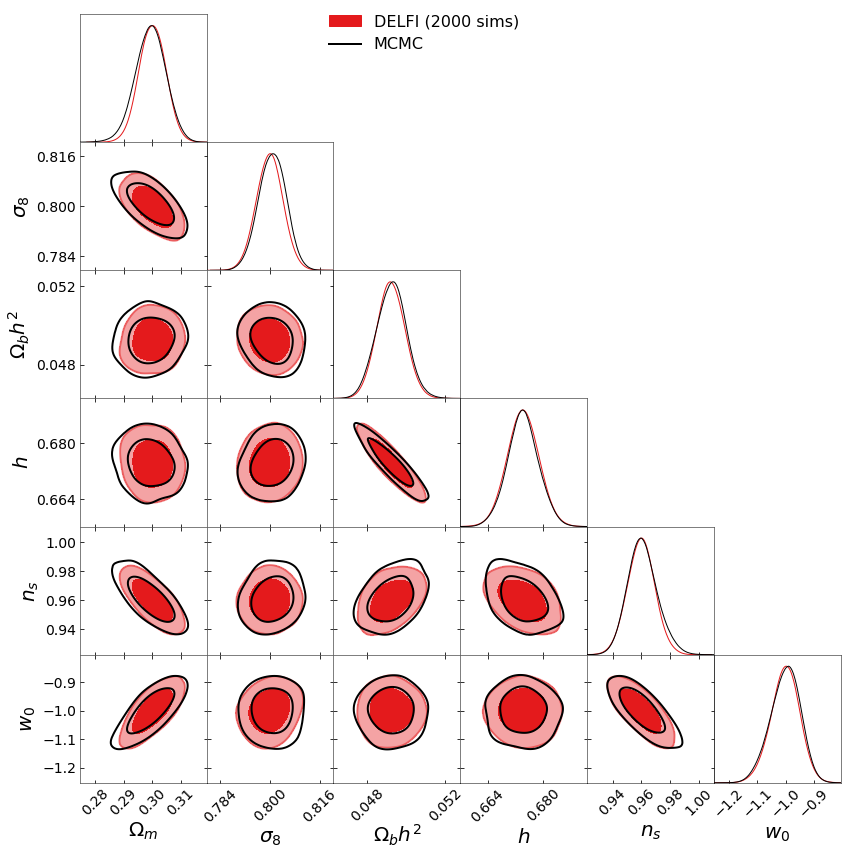

In [12]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5
samples_asymptotic[:,2] = samples_asymptotic[:,2]/samples_asymptotic[:,3]**2


samples_mcmc = np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_darkenergy.dat')
samples_mcmc[:,1] = samples_mcmc[:,1]*(0.3/samples_mcmc[:,0])**0.5
samples_mcmc[:,2] = samples_mcmc[:,2]/samples_mcmc[:,3]**2

samples_delfi = np.loadtxt('simulators/cosmic_shear/results_darkenergy/mdnposterior_samples_11.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
samples_delfi[:,2] = samples_delfi[:,2]/samples_delfi[:,3]**2
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'

samples = [samples_delfi, samples_mcmc]#, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False,False], normalized=[True,True,True], legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1, 1], contour_ls = ['-','-', '-.'], contour_colors=['#E41A1C','black', 'blue'])
g.add_legend(legend_labels=['DELFI (2000 sims)', 'MCMC', 'fisher matrix'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('../../paper_II/plots/cosmic_shear_contours_marginal_mcmc.pdf')

In [11]:
np.savetxt('simulators/cosmic_shear/mcmc/Finv_de.dat', Finv)